In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

In [2]:
data = pd.read_csv("dataset.csv")
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
data.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrollment                                 0
International                                     0
Curricular u

In [4]:
data.duplicated().sum()

np.int64(0)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [6]:
data=data[data.Target!='Enrolled']

In [7]:
data['Target']

0        Dropout
1       Graduate
2        Dropout
3       Graduate
4       Graduate
          ...   
4419    Graduate
4420     Dropout
4421     Dropout
4422    Graduate
4423    Graduate
Name: Target, Length: 3630, dtype: object

In [8]:
# ¶Features from sem 1 and 2 have similar correlations (without Curricular units 1st sem (without evaluations)) so can be removed to reduce redundancy and simplifying dataset. 
# Also International and Nacionality are not great predictors for target.
# From linear regression we find that Unemployment rate, Father's qualification, Inflation rate, Educational special needs dont really have any correlations with target.

In [9]:
data.drop(['International', 'Nacionality', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)','Curricular units 1st sem (approved)','Curricular units 1st sem (grade)', 'Curricular units 1st sem (evaluations)',"Father's qualification",'Unemployment rate','Inflation rate', 'Educational special needs'],axis=1,inplace=True)

In [10]:
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])

In [11]:
martial_status_map = {
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto Union',
    6: 'Legally Separated'
}
qualification_map = {
    1: '1st phase - general contingent',
    2: 'Ordinance No. 612/93',
    3: '1st phase - special contingent (Azores Island)',
    4: 'Holders of other higher courses',
    5: 'Ordinance No. 854-B/99',
    6: 'International student (bachelor)',
    7: '1st phase - special contingent (Madeira Island)',
    8: '2nd phase - general contingent',
    9: '3rd phase - general contingent',
    10: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    11: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    12: 'Over 23 years old',
    13: 'Transfer',
    14: 'Change of course',
    15: 'Technological specialization diploma holders',
    16: 'Change of institution/course',
    17: 'Short cycle diploma holders',
    18: 'Change of institution/course (International)'
}
course_map = {
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening attendance)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equinculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening attendance)'
}
attendance_map = {
    1: 'daytime',
    0: 'evening'
}
previous_qual_map = {
    1: 'Secondary education',
    2: "Bachelor's degree",
    3: 'Higher education - degree',
    4: 'Higher education - master\'s',
    5: 'Higher education - doctorate',
    6: 'Frequency of higher education',
    7: '12th year of schooling - not completed',
    8: '11th year of schooling - not completed',
    9: 'Other - 11th year of schooling',
    10: '10th year of schooling',
    11: '10th year of schooling - not completed',
    12: 'Basic education 3rd cycle (9th/10th/11th year) or equiv.',
    13: 'Basic education 2nd cycle (6th/7th/8th year) or equiv.',
    14: 'Technological specialization course',
    15: 'Higher education - degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education - master (2nd cycle)'
}
mothers_qual_map = {
    1: 'Secondary Education - 12th Year of Schooling or Eq.',
    2: 'Higher Education - Bachelor\'s Degree',
    3: 'Higher Education - Degree',
    4: 'Higher Education - Master\'s',
    5: 'Higher Education - Doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling - Not Completed',
    8: '11th Year of Schooling - Not Completed',
    9: '7th Year (Old)',
    10: 'Other - 11th Year of Schooling',
    11: '10th Year of Schooling',
    12: 'General commerce course',
    13: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.',
    14: 'Technical-professional course',
    15: '7th year of schooling',
    16: '2nd cycle of the general high school course',
    17: '9th Year of Schooling - Not Completed',
    18: '8th year of schooling',
    19: 'Unknown',
    20: 'Can\'t read or write',
    21: 'Can read without having a 4th year of schooling',
    22: 'Basic education 1st cycle (4th/5th year) or equiv.',
    23: 'Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.',
    24: 'Technological specialization course',
    25: 'Higher education - degree (1st cycle)',
    26: 'Specialized higher studies course',
    27: 'Professional higher technical course',
    28: 'Higher Education - Master (2nd cycle)',
    29: 'Higher Education - Doctorate (3rd cycle)'
}
mothers_occupation_map = {
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    8: 'Skilled Workers in Industry, Construction and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: 'Health professionals',
    14: 'Teachers',
    15: 'Specialists in information and communication technologies (ICT)',
    16: 'Intermediate level science and engineering technicians and professions',
    17: 'Technicians and professionals, of intermediate level of health',
    18: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    19: 'Office workers, secretaries in general and data processing operators',
    20: 'Data, accounting, statistical, financial services and registry-related operators',
    21: 'Other administrative support staff',
    22: 'Personal service workers',
    23: 'Sellers',
    24: 'Personal care workers and the like',
    25: 'Skilled construction workers and the like, except electricians',
    26: 'Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like',
    27: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    28: 'Cleaning workers',
    29: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    30: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    31: 'Meal preparation assistants',
    32: 'Nth'
}
fathers_occupation_map = {
    1: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    2: 'Specialists in Intellectual and Scientific Activities',
    3: 'Intermediate Level Technicians and Professions',
    4: 'Administrative staff',
    5: 'Personal Services, Security and Safety Workers and Sellers',
    6: 'Farmers and Skilled Workers in Agriculture, Fisheries and Forestry',
    7: 'Skilled Workers in Industry, Construction and Craftsmen',
    8: 'Installation and Machine Operators and Assembly Workers',
    9: 'Unskilled Workers',
    10: 'Armed Forces Professions',
    11: 'Directors of administrative and commercial services',
    12: 'Hotel, catering, trade and other services directors',
    13: 'Armed Forces Sergeants',
    14: 'Protection and security services personnel',
    15: 'Specialists in finance, accounting, administrative organization, public and commercial relations',
    16: 'Intermediate level science and engineering technicians and professions',
    17: 'Technicians and professionals, of intermediate level of health',
    18: 'Intermediate level technicians from legal, social, sports, cultural and similar services',
    20: 'Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence',
    21: 'Skilled construction workers and the like, except electricians',
    22: 'Skilled workers in metallurgy, metalworking and similar',
    23: 'Skilled workers in electricity and electronics',
    26: 'Workers in food processing, woodworking, clothing and other industries and crafts',
    27: 'Fixed plant and machine operators',
    28: 'Assembly workers',
    29: 'Vehicle drivers and mobile equipment operators',
    30: 'Unskilled workers in agriculture, animal production, fisheries and forestry',
    31: 'Unskilled workers in extractive industry, construction, manufacturing and transport',
    32: 'Meal preparation assistants',
    33: 'Street vendors (except food) and street service providers',
    35: 'Market-oriented farmers and skilled agricultural and animal production workers',
    36: 'Armed Forces Officers',
    37: 'Other Armed Forces personnel',
    38: 'Health professionals',
    39: 'Teachers',
    40: 'Specialists in the physical sciences, mathematics, engineering and related techniques',
    41: 'Data, accounting, statistical, financial services and registry-related operators',
    42: 'Other administrative support staff',
    43: 'Office workers, secretaries in general and data processing operators',
    44: 'Personal care workers and the like',
    45: 'Personal service workers',
    46: 'Sellers'
}

In [12]:
data['Marital status'] = data['Marital status'].replace(martial_status_map).astype("category")
data['Application mode'] = data['Application mode'].replace(qualification_map).astype("category")
data['Course'] = data['Course'].replace(course_map).astype("category")
data['Daytime/evening attendance'] = data['Daytime/evening attendance'].replace(attendance_map).astype("category")
data['Previous qualification'] = data['Previous qualification'].replace(previous_qual_map).astype("category")
data['Mother\'s qualification'] = data['Mother\'s qualification'].replace(mothers_qual_map).astype("category")
data['Mother\'s occupation'] = data['Mother\'s occupation'].replace(mothers_occupation_map).astype("category")
data['Father\'s occupation'] = data['Father\'s occupation'].replace(fathers_occupation_map).astype("category")
data['Debtor'] = data['Debtor'].replace({1: 'yes', 0: 'no'}).astype("category")
data['Tuition fees up to date'] = data['Tuition fees up to date'].replace({1: 'yes', 0: 'no'}).astype("category")
data['Gender'] = data['Gender'].replace({1: 'male', 0: 'female'}).astype("category")
data['Scholarship holder'] = data['Scholarship holder'].replace({1: 'yes', 0: 'no'}).astype("category")

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 24 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  3630 non-null   category
 1   Application mode                                3630 non-null   category
 2   Application order                               3630 non-null   int64   
 3   Course                                          3630 non-null   category
 4   Daytime/evening attendance                      3630 non-null   category
 5   Previous qualification                          3630 non-null   category
 6   Mother's qualification                          3630 non-null   category
 7   Mother's occupation                             3630 non-null   category
 8   Father's occupation                             3630 non-null   category
 9   Displaced                          

In [14]:
# Preparing data
X = data.drop('Target', axis=1)
y = data['Target']
# X = data.drop(columns=['Age at enrollment'])
# y = data['Age at enrollment']

In [15]:
# Categorization of the num and cat
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [17]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Sets binary collums for each cat variable
])

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [19]:
# 9. Try three models
models = {
    # "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42), # It creates multiple decision trees and merges them together to improve the accuracy
    "SVM": SVC() # default is kernel='rbf'
}

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Test size means that 20% of data will go to testing rest for trening

Accuracy of Logistic Regression: 0.9104683195592287
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       277
           1       0.91      0.95      0.93       449

    accuracy                           0.91       726
   macro avg       0.91      0.90      0.90       726
weighted avg       0.91      0.91      0.91       726



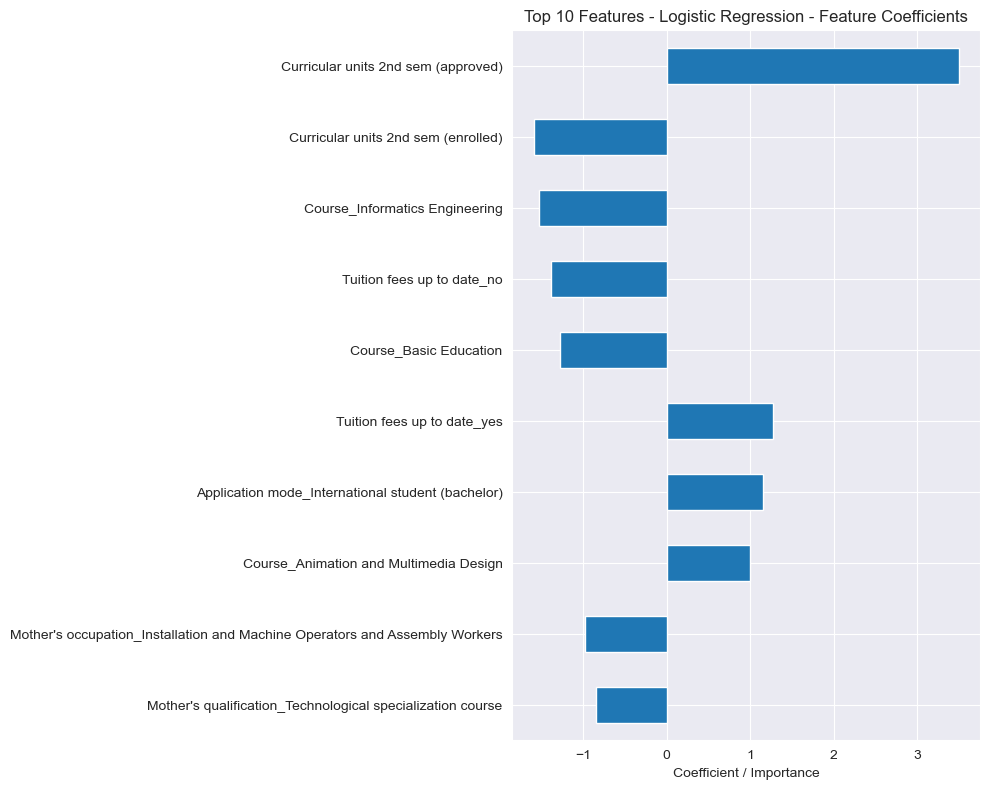

-------------------------------------------------------
Accuracy of RandomForest: 0.8980716253443526
Classification Report for RandomForest:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       277
           1       0.89      0.96      0.92       449

    accuracy                           0.90       726
   macro avg       0.90      0.88      0.89       726
weighted avg       0.90      0.90      0.90       726



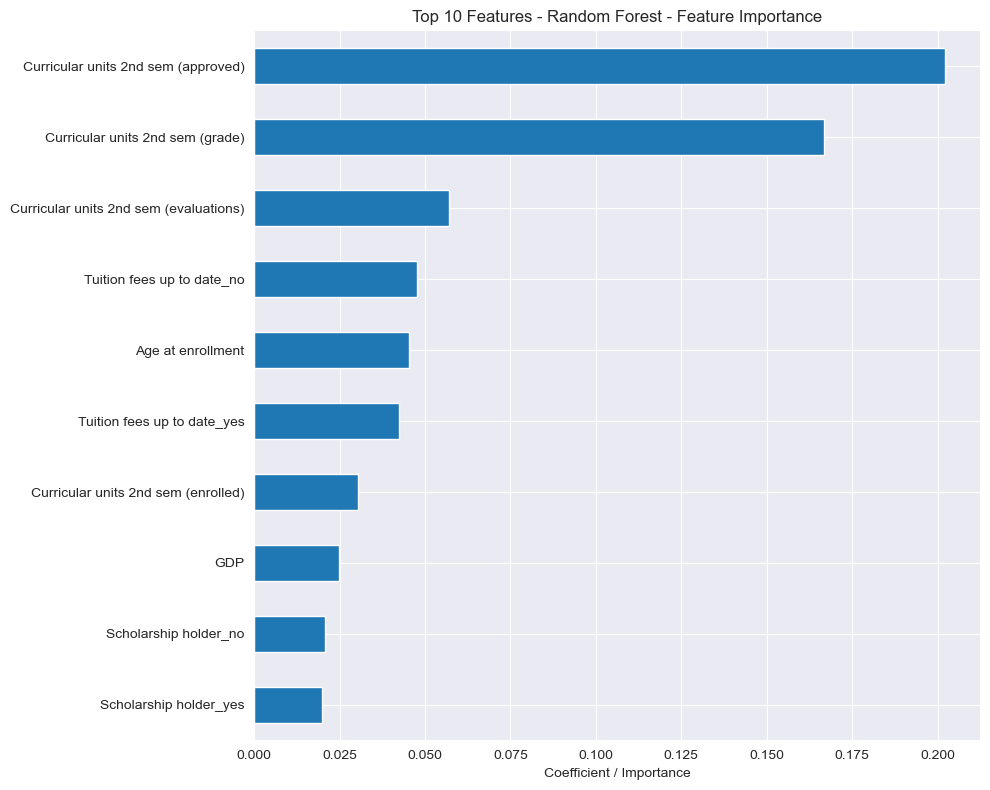

-------------------------------------------------------
Accuracy of SVM: 0.8953168044077136
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       277
           1       0.88      0.96      0.92       449

    accuracy                           0.90       726
   macro avg       0.90      0.88      0.89       726
weighted avg       0.90      0.90      0.89       726

-------------------------------------------------------


In [21]:
for model_name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Train the model
    clf.fit(X_train, y_train)
    # Predict on the test data
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy of {model_name}: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    
    # Feature names
    cat_features = clf.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    all_features = np.concatenate([numerical_cols, cat_features])
    
    # Feature importance or coefficients
    if model_name == "RandomForest":
        importances = clf.named_steps['classifier'].feature_importances_
        feature_importance = pd.Series(importances, index=all_features).sort_values(ascending=False)
        title = "Random Forest - Feature Importance"
        
    elif model_name == "Logistic Regression":
        coefs = clf.named_steps['classifier'].coef_[0]
        feature_importance = pd.Series(coefs, index=all_features).sort_values(key=abs, ascending=False)
        title = "Logistic Regression - Feature Coefficients"
        
    else:
        feature_importance = None  # SVM with RBF kernel – no coefficients

    # Plot if applicable
    if feature_importance is not None:
        plt.figure(figsize=(10, 8))
        feature_importance.head(10).plot(kind='barh')
        plt.xlabel("Coefficient / Importance")
        plt.title(f"Top 10 Features - {title}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print("-" * 55)


In [22]:
# Regression linear
X_np = X_train[numerical_cols].to_numpy()
y_np = y_train.to_numpy().reshape(-1, 1)

# Adding bias - col of 1
X_b = np.hstack([np.ones((X_np.shape[0], 1)), X_np])

# Closed formula: θ = (X^T X)^(-1) X^T y
theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y_np

y_pred = X_b @ theta

# Mse formula
mse = np.mean((y_pred - y_np) ** 2)

# R^2 formula 
ss_total = np.sum((y_np - np.mean(y_np)) ** 2)
ss_residual = np.sum((y_np - y_pred) ** 2)
r2 = 1 - (ss_residual / ss_total)

In [23]:
print(f"MSE (closed form): {mse:.4f}")
print(f"R^2: {r2:.4f}")

MSE (closed form): 0.0913
R^2: 0.6176


In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [25]:
def logistic_regression_gd(X, y, lr=0.1, epochs=1000): # epochs - liczba iteracji , lr - krok w minimalizacji kosztów
    m, n = X.shape # m - liczba obserwacji, n - liczba zmiennych wejściowych
    X = np.hstack([np.ones((m, 1)), X])  # Adding bias
    theta = np.zeros((n + 1, 1)) # wektor parametrów

    for _ in range(epochs):  # Powtarzamy proces aktualizacji theta przez epochs razy
        z = X @ theta # regresja liniowa
        predictions = sigmoid(z) # przekształcenie 
        error = predictions - y # obliczanie błędu 
        gradient = (1 / m) * X.T @ error # Obliczamy gradient funkcji kosztu CE
        theta -= lr * gradient # Uczymy model poprzez przesuwanie theta w stronę minimum funkcji kosztu.

    return theta

In [26]:
# Trening modelu
theta = logistic_regression_gd(X_np, y_np)

# Predykcja i ewaluacja
X_test_np = X_test[numerical_cols].to_numpy()
X_test_np = np.hstack([np.ones((X_test_np.shape[0], 1)), X_test_np])
y_test_np = y_test.to_numpy().reshape(-1, 1)

y_prob = sigmoid(X_test_np @ theta)
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy (logistic regression GD):", accuracy_score(y_test_np, y_pred))
print("Classification report:\n", classification_report(y_test_np, y_pred))

Accuracy (logistic regression GD): 0.8347107438016529
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.58      0.73       277
           1       0.79      0.99      0.88       449

    accuracy                           0.83       726
   macro avg       0.88      0.79      0.81       726
weighted avg       0.86      0.83      0.82       726



In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import sys
print("Python executable:", sys.executable)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Torch version:", torch.__version__)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

Python executable: C:\Users\kobla\anaconda3\envs\msid\python.exe
CUDA available: True
CUDA version: 12.1
Torch version: 2.5.1
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [28]:
X_tensor = torch.tensor(X_train[numerical_cols].to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1) 

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [29]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(X_tensor.shape[1], 1)  

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [30]:
def train_model_on_device(device_name):
    device = torch.device(device_name)
    model = LogisticRegressionModel().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.BCELoss()

    start_time = time.time()

    for epoch in range(100):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    end_time = time.time()
    print(f"Training on {device_name} took {end_time - start_time:.2f} seconds\n")

# Trening na CPU
train_model_on_device("cpu")

# Trening na GPU (jeśli dostępny)
if torch.cuda.is_available():
    train_model_on_device("cuda")
else:
    print("GPU not available.")

Training on cpu took 3.87 seconds

Training on cuda took 10.53 seconds

